# Labs 3

### Dostosuj aplikację graficzną tak, aby można było zadawać proste wielokąty przy użyciu myszki, z dodatkowym zapisem i odczytem podanych wielokątów. Wielokąty powinny być zadawane w kierunku przeciwnym do ruchu wskazówek zegara.

Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
%matplotlib notebook
import json as js
from math import inf

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

Interfejsy

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

Funkcje pomocnicze

In [3]:
def det(a, b, c, epsilon=10 ** (-12)):
    a_x, a_y = a
    b_x, b_y = b
    c_x, c_y = c
    first = (a_x - c_x) * (b_y - c_y)
    second = (a_y - c_y) * (b_x - c_x)
    determinant = first - second
    return determinant

def classify(a, b, c, starting, closing, connective, separative, correct, epsilon=10 ** (-12)):
    # starting or separative or correct
    if a[1] < b[1] and c[1] < b[1]:
        # starting
        if det(a, b, c) > epsilon:
            starting.append(b)
        # separative
        elif det(a, b, c) < -epsilon:
            separative.append(b)

    # closing or connective or correct
    elif a[1] > b[1] and c[1] > b[1]:
        # closing
        if det(a, b, c) > epsilon:
            closing.append(b)
        # connective
        elif det(a, b, c) < -epsilon:
            connective.append(b)

    # correct
    else:
        correct.append(b)
        
def convert_to_lines(points):
    lines = []
    for p in range(len(points)-1):
        lines.append((points[p], points[p+1]))
    lines.append((points[-1], points[0]))
    return lines

def connective_or_separative(a, b, c, epsilon = 10 ** (-12)):
    determinant = det(a, b, c)
    if a[1] > b[1] and c[1] > b[1] and determinant < -epsilon:
        return True
    elif a[1] < b[1] and c[1] < b[1] and determinant < -epsilon:
        return True
    return False

---
### Zaimplementuj procedurę sprawdzającą, czy podany wielokąt jest y-monotoniczny. W sprawozdaniu opisz krótko tę metodę sprawdzania.

In [4]:
def y_monotonic(points):
    for i in range(0, len(points)-1):
        if connective_or_separative(points[i-1], points[i], points[i+1]):
            return False
    
    if connective_or_separative(points[-2], points[-1], points[0]):
        return False
    return True

---
### Zaimplementuj algorytm, który dla zadanego wielokąta będzie wyszukiwał wierzchołki początkowe, końcowe, łączące, dzielące i prawidłowe. Wierzchołki mają zostać odpowiednio pokolorowane zgodnie z klasyfikacją.

Legenda:
 - green (zielony) - starting (wierzchołek początkowy),
 - red (czerwony) - closing (wierzchołek końcowy),
 - dark blue (ciemnoniebieski) - connective (wierzchołek łączący),
 - light blue (jasnoniebieski) - separative (wierzchołek dzielący),
 - saddlebrown (brązowy) - correct (wierzchołek prawidłowy). 

In [5]:
def classify_points(points):
    starting = []
    closing = []
    connective = []
    separative = []
    correct = []
    # all points excep first and last
    for i in range(0, len(points)-1):
        classify(points[i-1], points[i], points[i+1], starting, closing, connective, separative, correct)
    
    # last point
    classify(points[-2], points[-1], points[0], starting, closing, connective, separative, correct)
    
    return starting, closing, connective, separative, correct

In [6]:
def draw_classification(points, starting, closing, connective, separative, correct):
    plot = Plot(points = [PointsCollection(starting, color = "green"),
                          PointsCollection(closing, color = "red"),
                          PointsCollection(connective, color = "darkblue"),
                          PointsCollection(separative, color = "lightblue"),
                          PointsCollection(correct, color = "saddlebrown")],
             lines=[LinesCollection(convert_to_lines(points), color = "black")])
    
    plot.draw()

---
### Zaimplementuj procedurę triangulacji wielokąta monotonicznego (zgodnie z algorytmem opisanym na wykładzie). Program powinien pokazywać kolejne kroki algorytmu (tzn. kolejne tworzone trójkąty).

Funkcje pomocniczne

In [7]:
def find_chains(points):
    right_chain = set()
    left_chain = set()
    starting = points.index(max(points, key=lambda x: x[1]))
    ending = points.index(min(points, key=lambda x: x[1]))
    i = ending
    while i != starting:
        right_chain.add(points[i])
        i = (i + 1) % len(points)
    while i != ending:
        left_chain.add(points[i])
        i = (i + 1) % len(points)
    return left_chain, right_chain


def check_same_chains(left_chain, right_chain, point1, point2):
    if (point1 in left_chain and point2 in left_chain) or (point1 in right_chain and point2 in right_chain):
        return True
    return False

def triangle_in_polygon(chain, a, b, c, epsilon=10 ** (-12)):
    if b in chain:
        return det(a, b, c) > epsilon
    else:
        return det(a, b, c) < -epsilon


def check_neighbours(points, a, b):
    a_index = points.index(a)
    b_index = points.index(b)
    if abs(a_index - b_index) == 1:
        return True
    elif abs(a_index - b_index) == len(points) - 1:
        return True
    return False

In [8]:
def triangulation(points):
    if not y_monotonic(points):
        print("Polygon is not y-monotonic.")
        return None, None
    print("Polygon is y-monotonic.")
    lines = convert_to_lines(points)
    scenes = [Scene(points=[PointsCollection(points, color='green')],
                    lines=[LinesCollection(lines, color='black')])]

    points_copy = points[:]
    left_chain, right_chain = find_chains(points)
    points.sort(key=lambda x: x[1], reverse=True)

    stack = [points[0], points[1]]
    diagonals = []
    for i in range(2, len(points)):
        curr_diagonals = diagonals[:]
        curr_stack = stack[:]
        scenes.append(Scene(points=[PointsCollection(points, color="green"),
                                    PointsCollection(curr_stack, color="red"),
                                    PointsCollection([points[i]], color="yellow")],
                            lines=[LinesCollection(lines, color="black"),
                                   LinesCollection(curr_diagonals, color="blue")]))
        if not check_same_chains(left_chain, right_chain, stack[-1], points[i]):
            while len(stack) > 0:
                p = stack.pop()
                if not check_neighbours(points_copy, p, points[i]):
                    diagonals.append((points[i], p))
                curr_diagonals = diagonals[:]
                curr_stack = stack[:]
                scenes.append(Scene(points=[PointsCollection(points, color="green"),
                                            PointsCollection(curr_stack, color="red"),
                                            PointsCollection([points[i]], color="yellow"),
                                            PointsCollection([p], color="purple")],
                                    lines=[LinesCollection(lines, color="black"),
                                           LinesCollection(curr_diagonals, color="blue")]))
            stack.append(points[i - 1])
            stack.append(points[i])
        else:
            p = stack.pop()
            while len(stack) > 0 and triangle_in_polygon(left_chain, stack[-1], p, points[i]):
                if not check_neighbours(points_copy, p, points[i]) and \
                        (points[i], p) not in diagonals:
                    diagonals.append((points[i], p))
                if not check_neighbours(points_copy, stack[-1], points[i]) and \
                        (points[i], stack[-1]) not in diagonals:
                    diagonals.append((points[i], stack[-1]))
                p = stack.pop()
                curr_diagonals = diagonals[:]
                curr_stack = stack[:]
                scenes.append(Scene(points=[PointsCollection(points, color="green"),
                                            PointsCollection(curr_stack, color="red"),
                                            PointsCollection([points[i]], color="yellow"),
                                            PointsCollection([p], color="purple")],
                                    lines=[LinesCollection(lines, color="black"),
                                           LinesCollection(curr_diagonals, color="blue")]))
            stack.append(p)
            stack.append(points[i])
    curr_diagonals = diagonals[:]
    scenes.append(Scene(points=[PointsCollection(points, color="green")],
                                    lines=[LinesCollection(lines, color="black"),
                                           LinesCollection(curr_diagonals, color="blue")]))
    return diagonals, scenes

---
### Przetestuj programy na różnych zestawach danych. W sprawozdaniu napisz, jakiego typu zestawy testowano. Uzasadnij wybór danych testujących.

Funkcja zwracająca punkty z rysunku

In [9]:
def points_from_plot(plot):
    points = []
    lines = plot.get_added_figure()[0].lines
    for l in lines:
        points.append(l[0])
    points.append(lines[len(lines) - 1][1])
    return points

Wykresy do testów

<IPython.core.display.Javascript object>


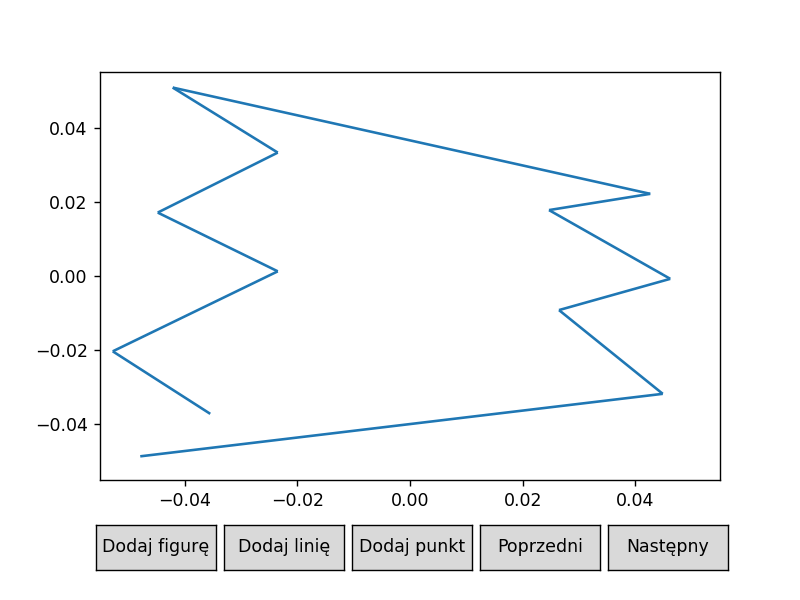

In [10]:
plot_1 = Plot()
plot_1.draw()

<IPython.core.display.Javascript object>


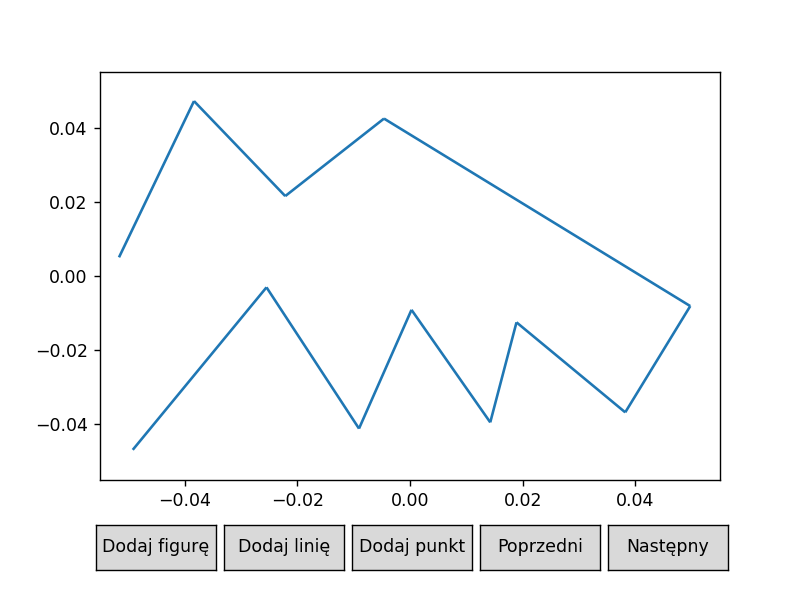

In [11]:
plot_2 = Plot()
plot_2.draw()

<IPython.core.display.Javascript object>


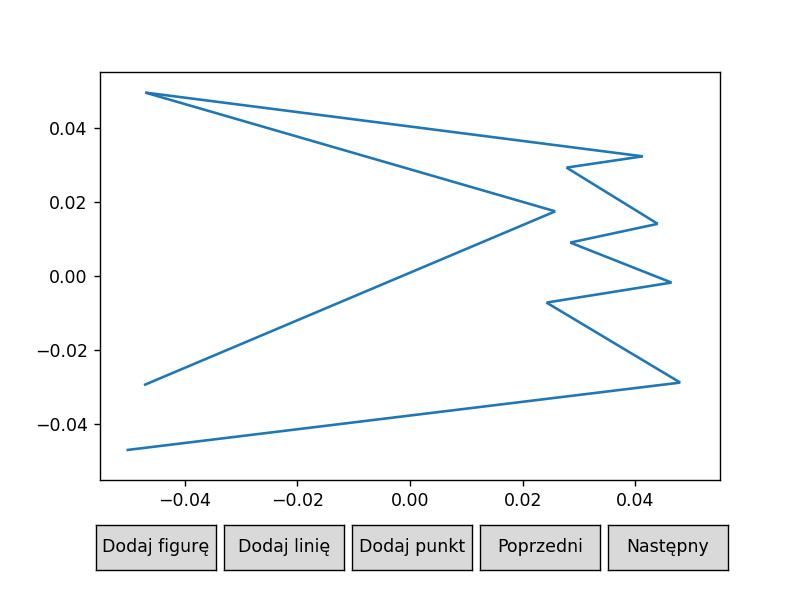

In [12]:
plot_3 = Plot()
plot_3.draw()

<IPython.core.display.Javascript object>


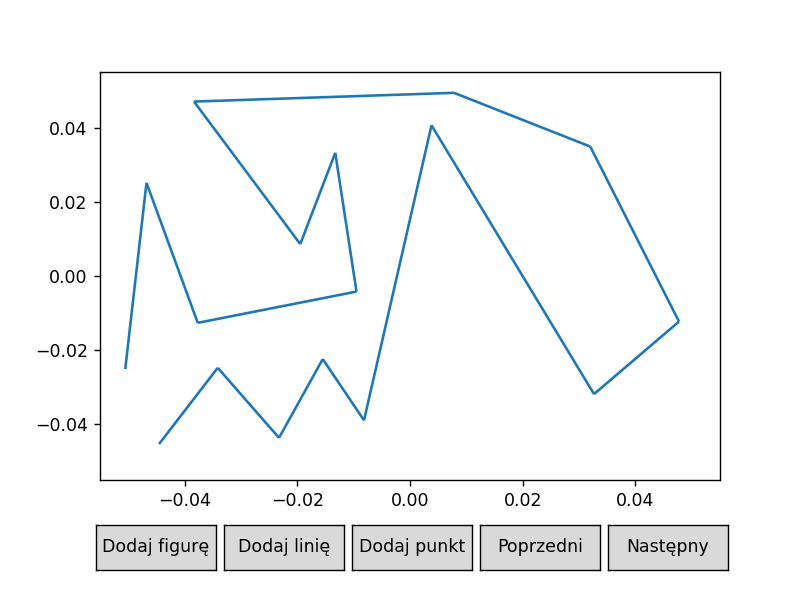

In [13]:
plot_4 = Plot()
plot_4.draw()

<IPython.core.display.Javascript object>


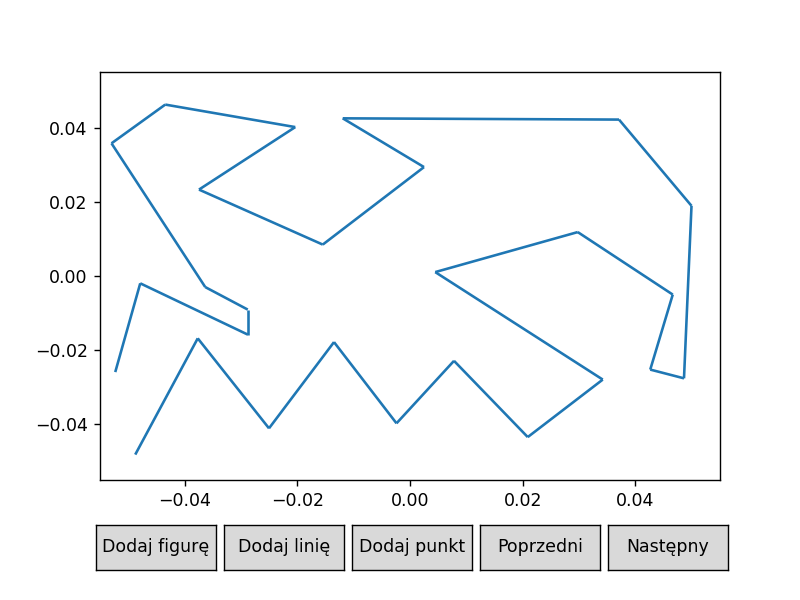

In [14]:
plot_5 = Plot()
plot_5.draw()

<IPython.core.display.Javascript object>


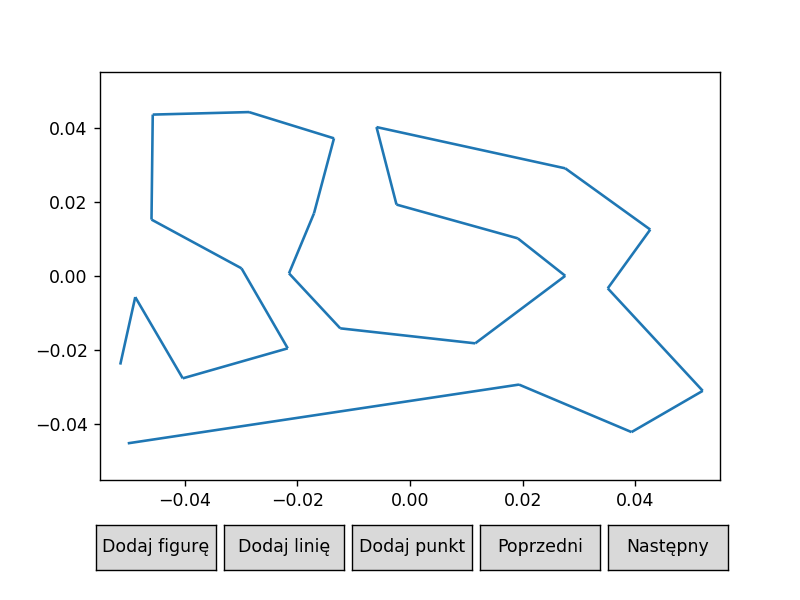

In [15]:
plot_6 = Plot()
plot_6.draw()

<IPython.core.display.Javascript object>


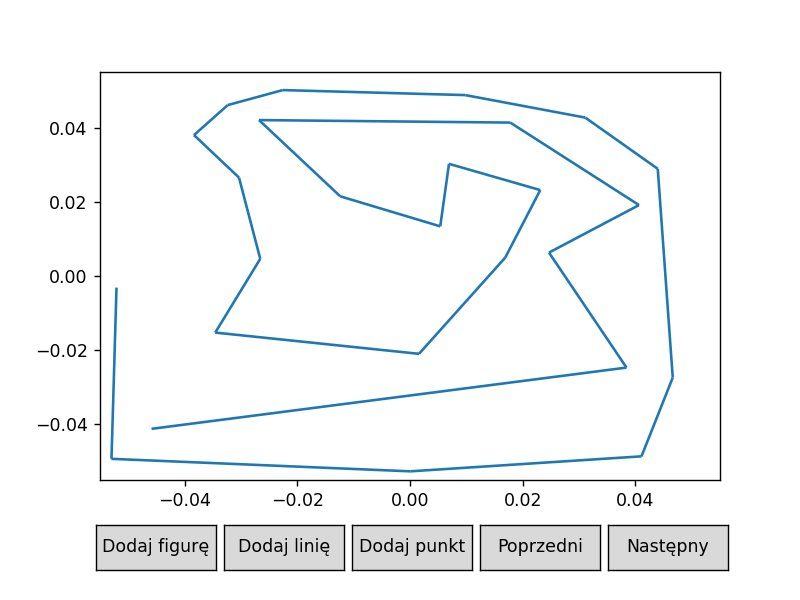

In [16]:
plot_7 = Plot()
plot_7.draw()

<IPython.core.display.Javascript object>


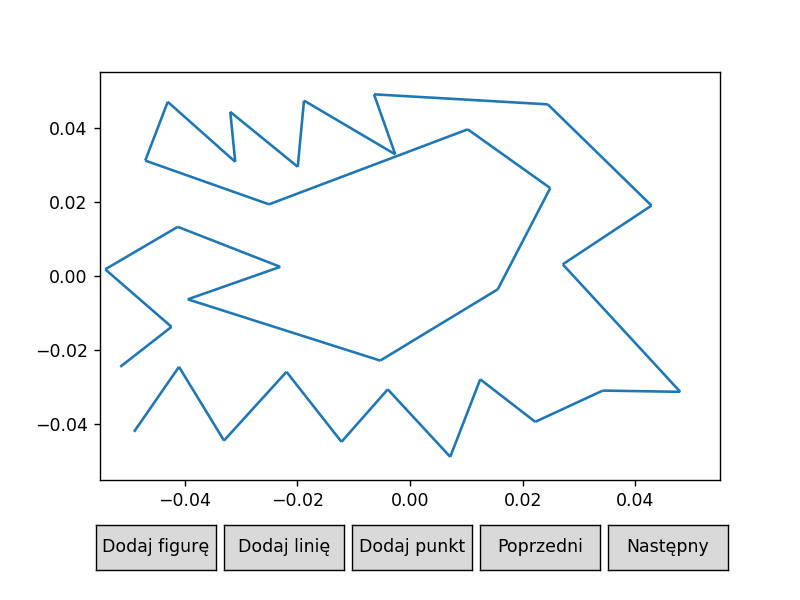

In [17]:
plot_8 = Plot()
plot_8.draw()

<IPython.core.display.Javascript object>


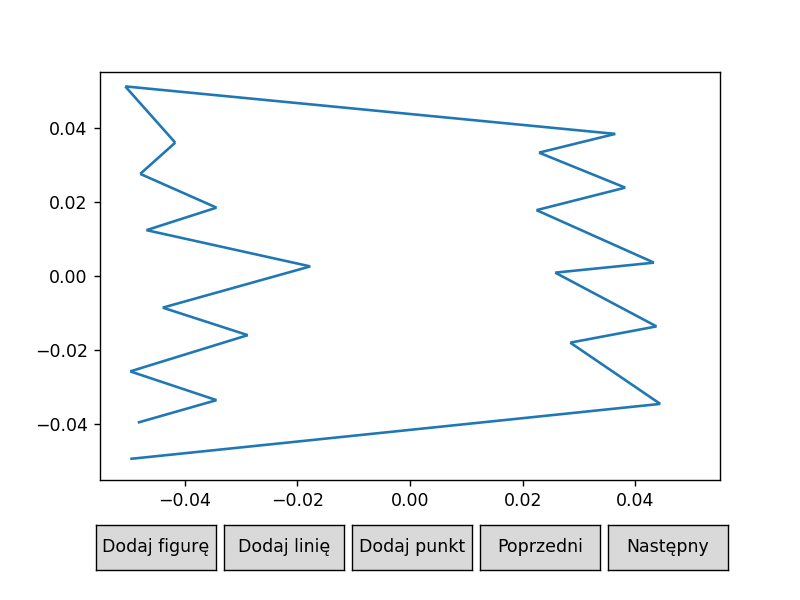

In [18]:
plot_9 = Plot()
plot_9.draw()

<IPython.core.display.Javascript object>


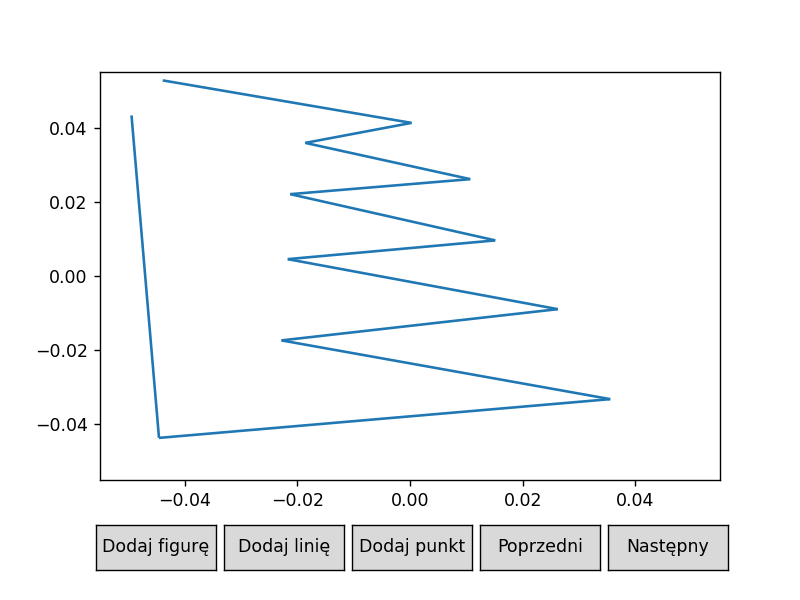

In [19]:
plot_10 = Plot()
plot_10.draw()

<IPython.core.display.Javascript object>


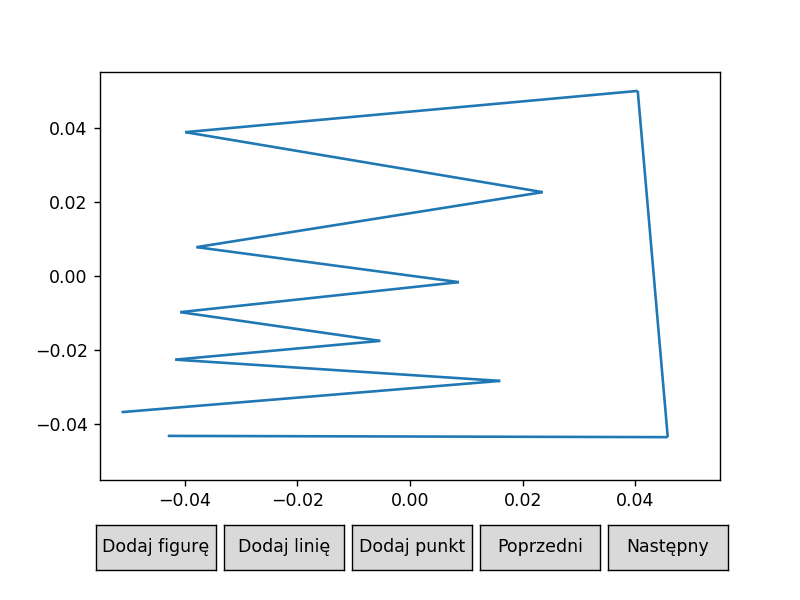

In [20]:
plot_11 = Plot()
plot_11.draw()

<IPython.core.display.Javascript object>


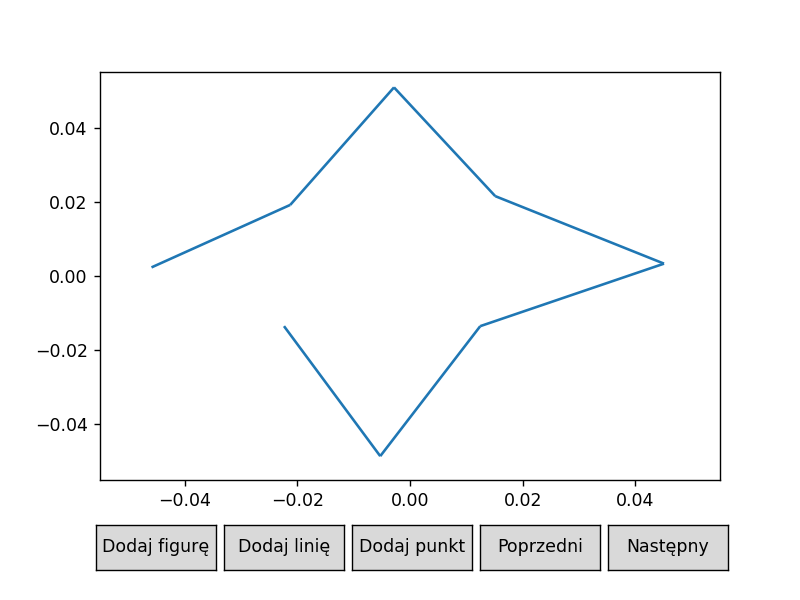

In [21]:
plot_12 = Plot()
plot_12.draw()

<IPython.core.display.Javascript object>


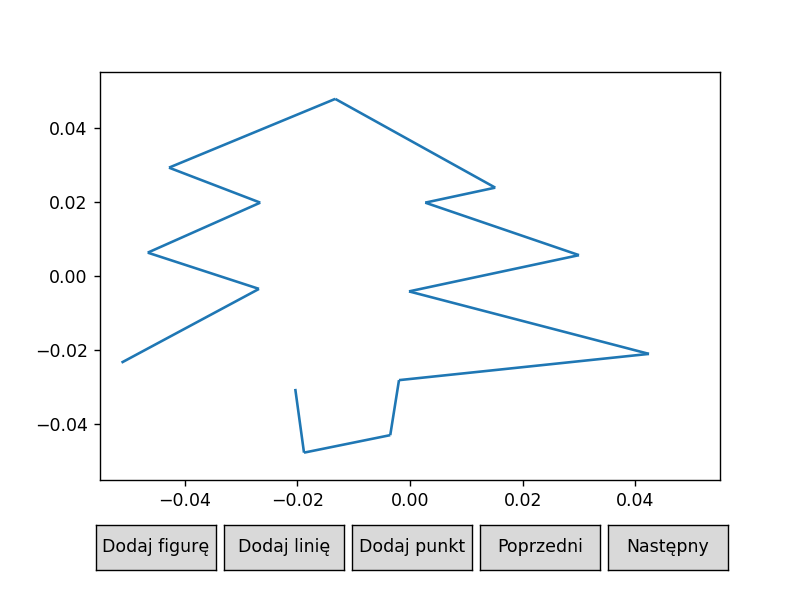

In [22]:
plot_13 = Plot()
plot_13.draw()

<IPython.core.display.Javascript object>


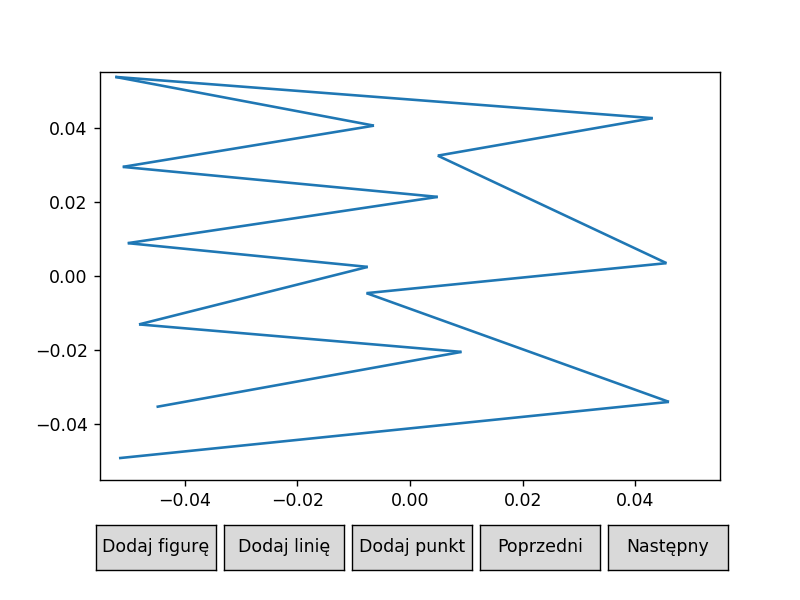

In [23]:
plot_14 = Plot()
plot_14.draw()

<IPython.core.display.Javascript object>


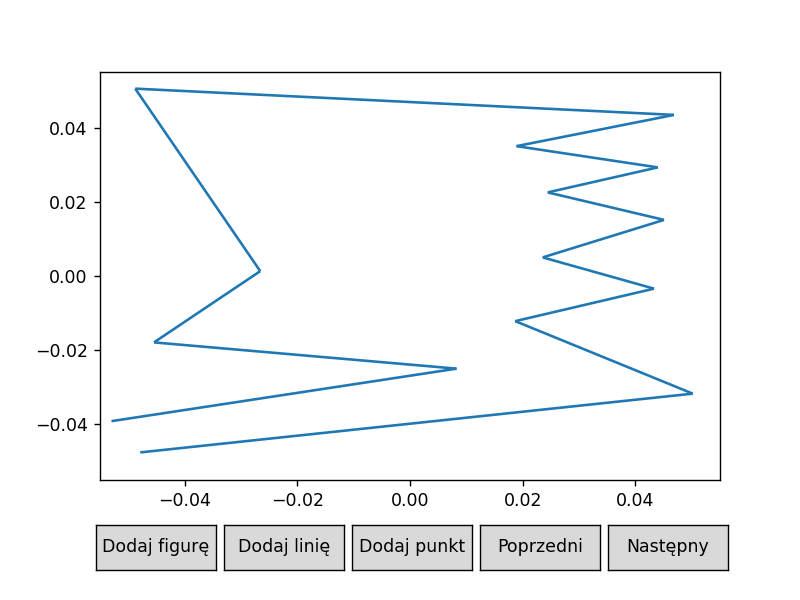

In [24]:
plot_15 = Plot()
plot_15.draw()

**1) Test czy wielokąt jest y-monotoniczny**

In [25]:
points_1 = points_from_plot(plot_1)
print(y_monotonic(points_1))

True


In [26]:
points_2 = points_from_plot(plot_2)
print(y_monotonic(points_2))

False


In [27]:
points_3 = points_from_plot(plot_3)
print(y_monotonic(points_3))

True


In [28]:
points_4 = points_from_plot(plot_4)
print(y_monotonic(points_4))

False


**2) Test klasyfikacji punktów**

Legenda:
 - green (zielony) - starting (wierzchołek początkowy),
 - red (czerwony) - closing (wierzchołek końcowy),
 - dark blue (ciemnoniebieski) - connective (wierzchołek łączący),
 - light blue (jasnoniebieski) - separative (wierzchołek dzielący),
 - saddlebrown (brązowy) - correct (wierzchołek prawidłowy). 

<IPython.core.display.Javascript object>


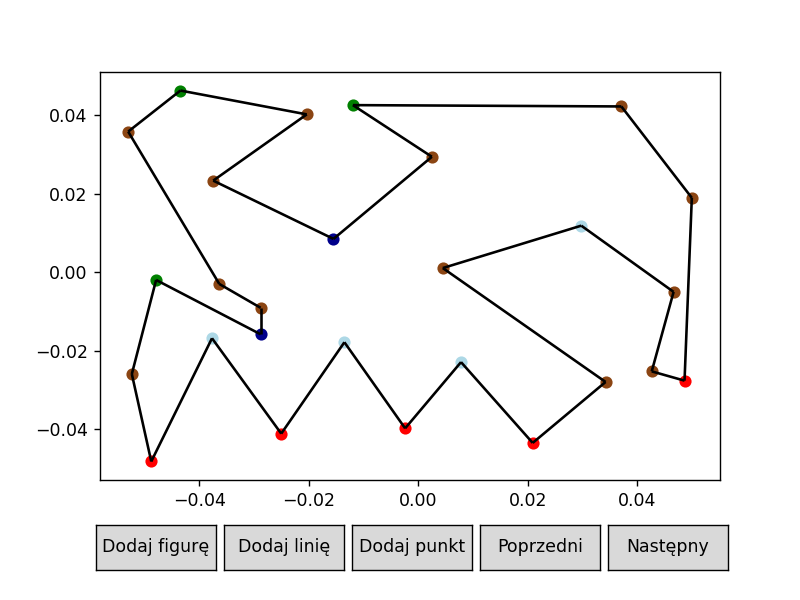

In [29]:
points_5 = points_from_plot(plot_5)
starting_5, closing_5, connective_5, separative_5, correct_5 = classify_points(points_5)
draw_classification(points_5, starting_5, closing_5, connective_5, separative_5, correct_5)

<IPython.core.display.Javascript object>


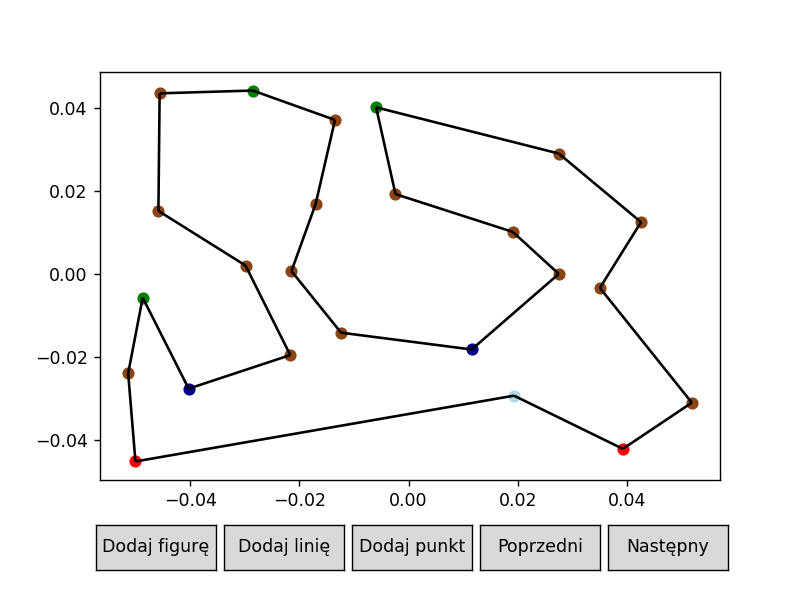

In [30]:
points_6 = points_from_plot(plot_6)
starting_6, closing_6, connective_6, separative_6, correct_6 = classify_points(points_6)
draw_classification(points_6, starting_6, closing_6, connective_6, separative_6, correct_6)

<IPython.core.display.Javascript object>


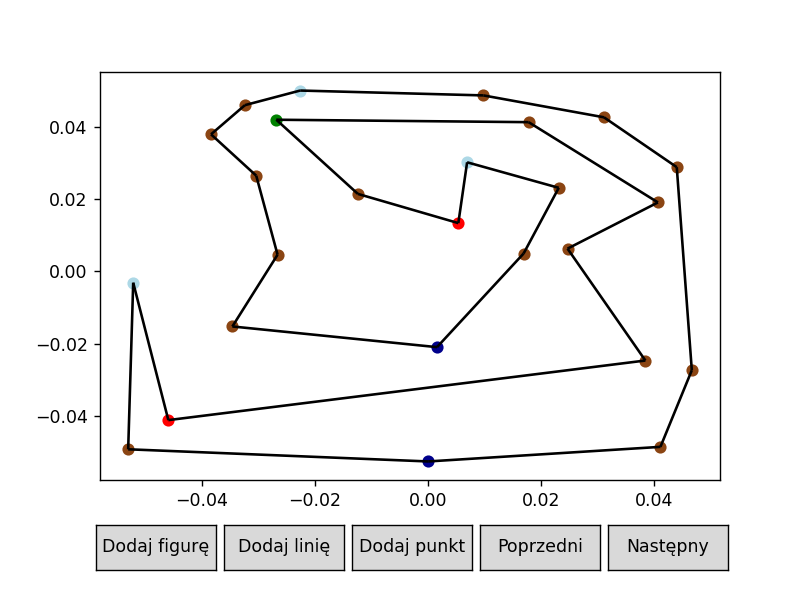

In [31]:
points_7 = points_from_plot(plot_7)
starting_7, closing_7, connective_7, separative_7, correct_7 = classify_points(points_7)
draw_classification(points_7, starting_7, closing_7, connective_7, separative_7, correct_7)

<IPython.core.display.Javascript object>


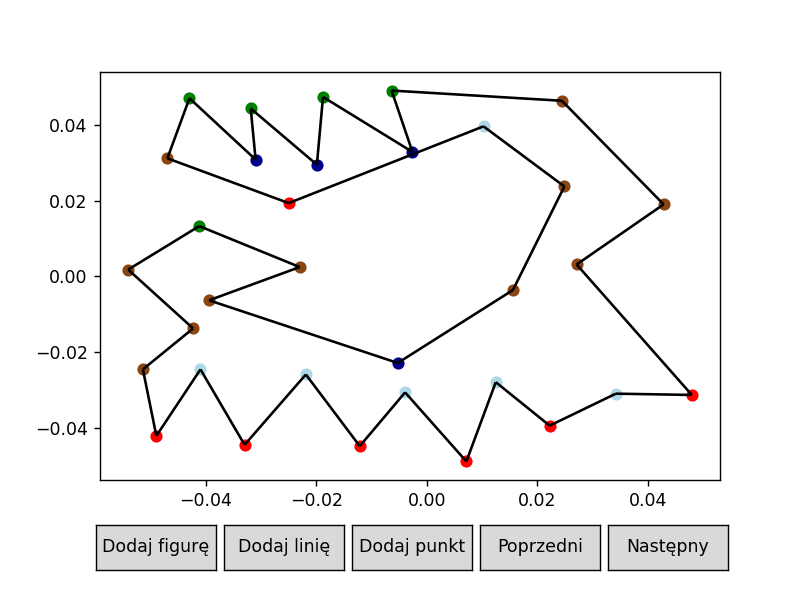

In [32]:
points_8 = points_from_plot(plot_8)
starting_8, closing_8, connective_8, separative_8, correct_8 = classify_points(points_8)
draw_classification(points_8, starting_8, closing_8, connective_8, separative_8, correct_8)

**3) Test triangulacji**

Polygon is y-monotonic.
Number of diagonals is 18.
Diagonals: [((-0.0416491908411826, 0.03595332856271782), (0.03641532528784967, 0.03831239719016881)), ((0.022887099481398054, 0.03325725013134527), (-0.0416491908411826, 0.03595332856271782)), ((-0.04785886826053744, 0.02752808346467861), (0.022887099481398054, 0.03325725013134527)), ((0.038189518836236766, 0.023820975621541354), (-0.04785886826053744, 0.02752808346467861)), ((-0.03433064245408582, 0.018428818758796248), (0.038189518836236766, 0.023820975621541354)), ((0.02244355109430128, 0.017754799150953113), (-0.03433064245408582, 0.018428818758796248)), ((-0.0467499972927955, 0.012362642288208006), (0.02244355109430128, 0.017754799150953113)), ((0.043290325287849665, 0.003600387386247225), (-0.0467499972927955, 0.012362642288208006)), ((-0.017697577937956788, 0.002589357974482523), (0.043290325287849665, 0.003600387386247225)), ((0.025770163997527087, 0.0009043089548746719), (-0.017697577937956788, 0.002589357974482523)), ((-0.043

<IPython.core.display.Javascript object>


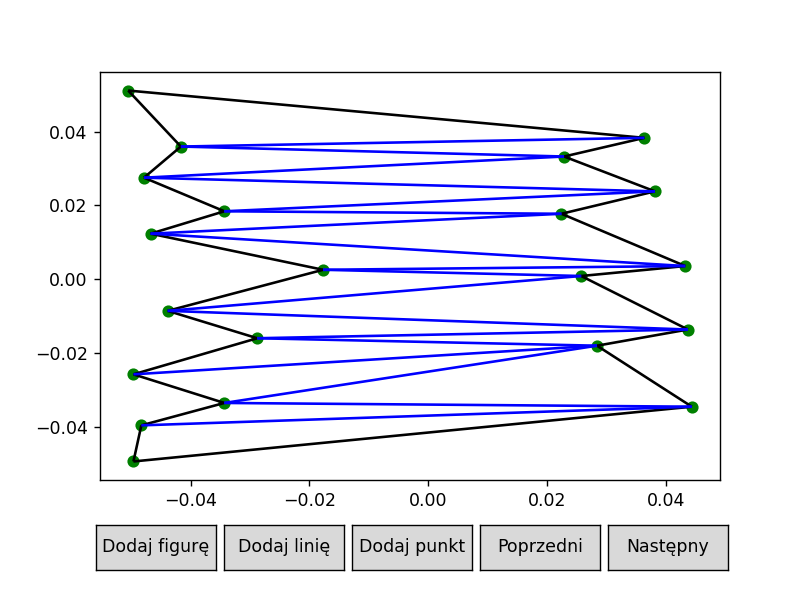

In [33]:
points_9 = points_from_plot(plot_9)
diagonals_9, scenes_9 = triangulation(points_9)
plot_9 = Plot(scenes_9)
print(f'Number of diagonals is {len(diagonals_9)}.')
print(f'Diagonals: {diagonals_9}.')
plot_9.draw()

Polygon is y-monotonic.
Number of diagonals is 9.
Diagonals: [((0.0002661317394625634, 0.041278084493150916), (-0.049411287615376144, 0.04330014331668032)), ((-0.018584674712150334, 0.03588592763040581), (-0.049411287615376144, 0.04330014331668032)), ((0.01068951883623677, 0.026112643316680312), (-0.049411287615376144, 0.04330014331668032)), ((-0.02124596503473098, 0.02206852566962149), (-0.049411287615376144, 0.04330014331668032)), ((-0.021689513421827754, 0.004544015865699913), (-0.02124596503473098, 0.02206852566962149)), ((-0.021689513421827754, 0.004544015865699913), (-0.049411287615376144, 0.04330014331668032)), ((-0.022798384389569687, -0.017361621389202053), (-0.021689513421827754, 0.004544015865699913)), ((-0.022798384389569687, -0.017361621389202053), (-0.049411287615376144, 0.04330014331668032)), ((-0.04453225535731163, -0.04364838609508441), (-0.022798384389569687, -0.017361621389202053))].


<IPython.core.display.Javascript object>


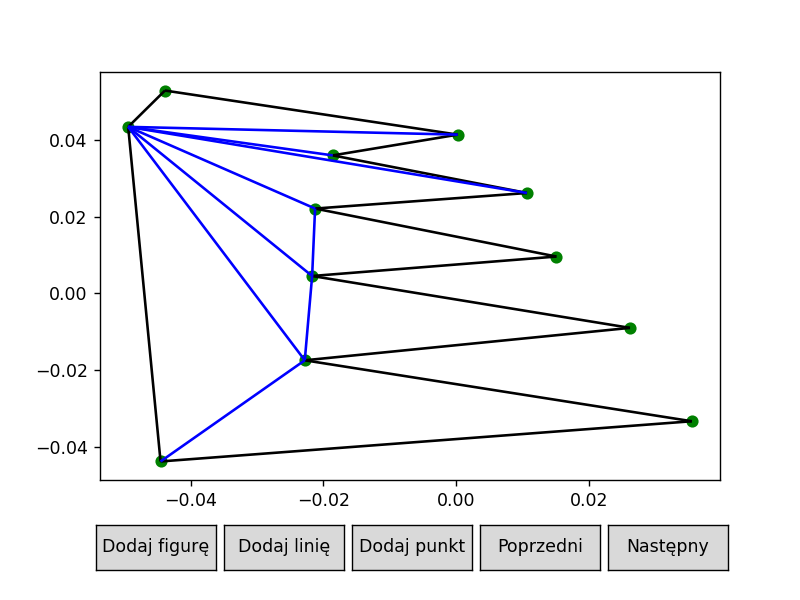

In [34]:
points_10 = points_from_plot(plot_10)
diagonals_10, scenes_10 = triangulation(points_10)
plot_10 = Plot(scenes_10)
print(f'Number of diagonals is {len(diagonals_10)}.')
print(f'Diagonals: {diagonals_10}.')
plot_10.draw()

Polygon is y-monotonic.
Number of diagonals is 9.
Diagonals: [((0.02355242206204322, 0.02260774341284061), (0.04040726077172063, 0.04990553753048767)), ((0.008693551094301283, -0.0016569624695123436), (0.02355242206204322, 0.02260774341284061)), ((0.008693551094301283, -0.0016569624695123436), (0.04040726077172063, 0.04990553753048767)), ((-0.005278223099247109, -0.01749642325382607), (0.008693551094301283, -0.0016569624695123436)), ((0.01601209948139805, -0.028280736979316275), (-0.005278223099247109, -0.01749642325382607)), ((0.01601209948139805, -0.028280736979316275), (0.008693551094301283, -0.0016569624695123436)), ((0.01601209948139805, -0.028280736979316275), (0.04040726077172063, 0.04990553753048767)), ((-0.04297983600247292, -0.0431091683518653), (0.01601209948139805, -0.028280736979316275)), ((0.045729841416881925, -0.043446178155786865), (0.01601209948139805, -0.028280736979316275))].


<IPython.core.display.Javascript object>


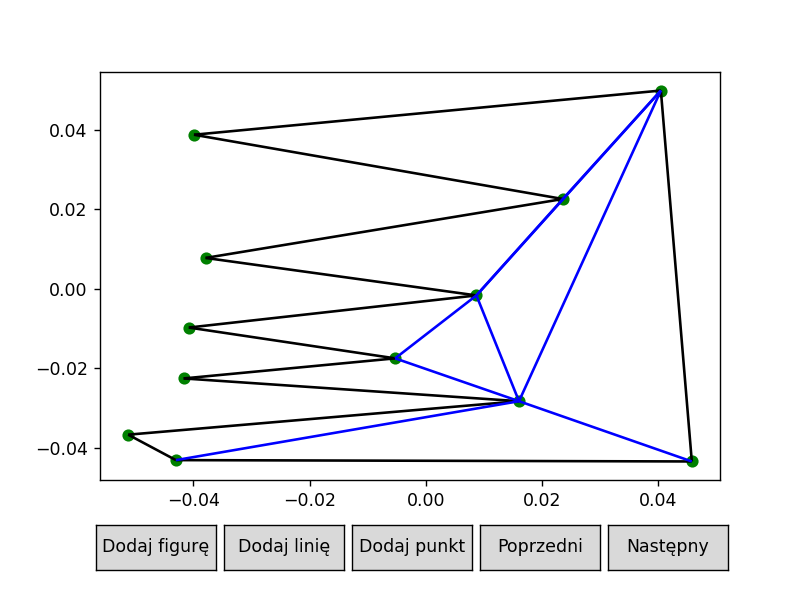

In [35]:
points_11 = points_from_plot(plot_11)
diagonals_11, scenes_11 = triangulation(points_11)
plot_11 = Plot(scenes_11)
print(f'Number of diagonals is {len(diagonals_11)}.')
print(f'Diagonals: {diagonals_11}.')
plot_11.draw()

Polygon is y-monotonic.
Number of diagonals is 5.
Diagonals: [((-0.02124596503473098, 0.019170239298951397), (0.015125002707204502, 0.021529307926402383)), ((0.04506451883623677, 0.0033307785146376723), (-0.02124596503473098, 0.019170239298951397)), ((-0.04586290051860195, 0.002319749102872956), (0.04506451883623677, 0.0033307785146376723)), ((-0.022354836002472914, -0.013519711681440769), (0.04506451883623677, 0.0033307785146376723)), ((0.012463712384623862, -0.013519711681440769), (-0.022354836002472914, -0.013519711681440769))].


<IPython.core.display.Javascript object>


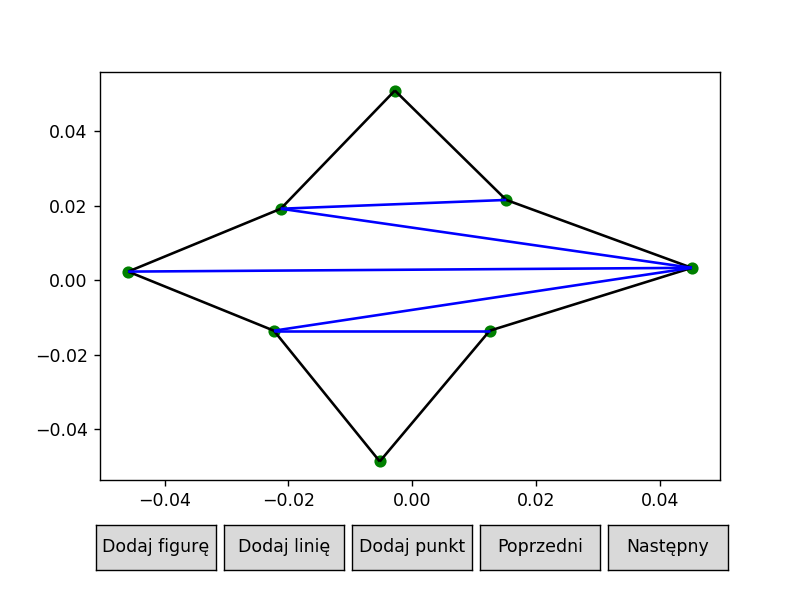

In [36]:
points_12 = points_from_plot(plot_12)
diagonals_12, scenes_12 = triangulation(points_12)
plot_12 = Plot(scenes_12)
print(f'Number of diagonals is {len(diagonals_12)}.')
print(f'Diagonals: {diagonals_12}.')
plot_12.draw()

Polygon is y-monotonic.
Number of diagonals is 12.
Diagonals: [((0.015125002707204502, 0.023820975621541354), (-0.04275806180892453, 0.029213132484286447)), ((0.002705647868494823, 0.019776857974482517), (-0.04275806180892453, 0.029213132484286447)), ((-0.026568545679892273, 0.019776857974482517), (0.002705647868494823, 0.019776857974482517)), ((-0.04652822309924711, 0.0062964658176197785), (0.002705647868494823, 0.019776857974482517)), ((0.02998387367494644, 0.00562244620977663), (-0.04652822309924711, 0.0062964658176197785)), ((-0.02679031987344066, -0.0034768184961057186), (0.02998387367494644, 0.00562244620977663)), ((-0.00017741664763420983, -0.0041508381039488534), (-0.02679031987344066, -0.0034768184961057186)), ((0.04240322851365612, -0.021001328300027294), (-0.02679031987344066, -0.0034768184961057186)), ((-0.051185481163763244, -0.02336039692747828), (0.04240322851365612, -0.021001328300027294)), ((-0.0019516101960213028, -0.028078534182380238), (-0.051185481163763244, -0.023

<IPython.core.display.Javascript object>


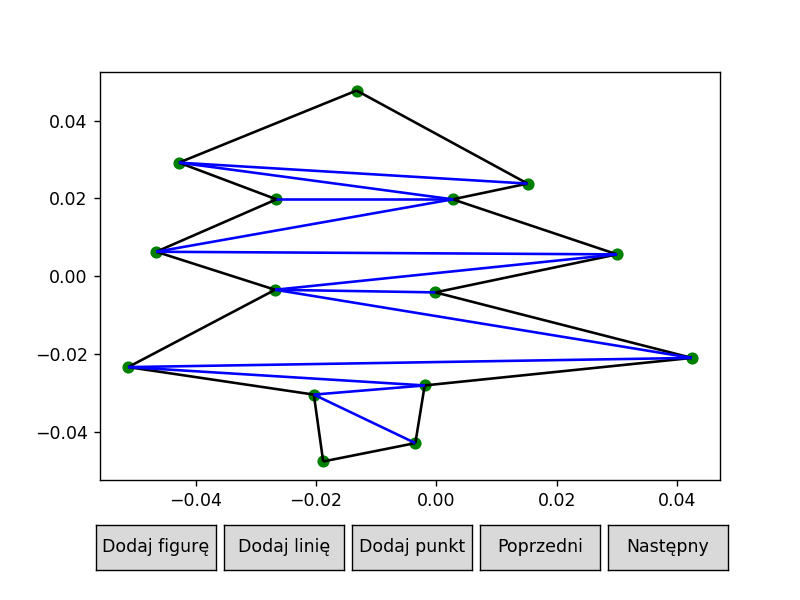

In [37]:
points_13 = points_from_plot(plot_13)
diagonals_13, scenes_13 = triangulation(points_13)
plot_13 = Plot(scenes_13)
print(f'Number of diagonals is {len(diagonals_13)}.')
print(f'Diagonals: {diagonals_13}.')
plot_13.draw()

Polygon is y-monotonic.
Number of diagonals is 12.
Diagonals: [((-0.006387094066989049, 0.04053666395299575), (0.043068551094301286, 0.042558722776525185)), ((0.004923389803978703, 0.032448428658878106), (-0.006387094066989049, 0.04053666395299575)), ((-0.05096370697021485, 0.029415340423584), (0.004923389803978703, 0.032448428658878106)), ((0.004923389803978703, 0.02132710512946634), (0.004923389803978703, 0.032448428658878106)), ((0.045508067223333545, 0.0034655855216231962), (-0.050076610196021304, 0.008857742384368303)), ((0.045508067223333545, 0.0034655855216231962), (0.004923389803978703, 0.02132710512946634)), ((-0.007495965034730975, 0.002454556109858494), (0.045508067223333545, 0.0034655855216231962)), ((-0.007717739228279369, -0.00462264977249445), (-0.007495965034730975, 0.002454556109858494)), ((-0.04808064245408582, -0.013047894870533663), (-0.007717739228279369, -0.00462264977249445)), ((0.009137099481398056, -0.020462110556808175), (-0.007717739228279369, -0.004622649772

<IPython.core.display.Javascript object>


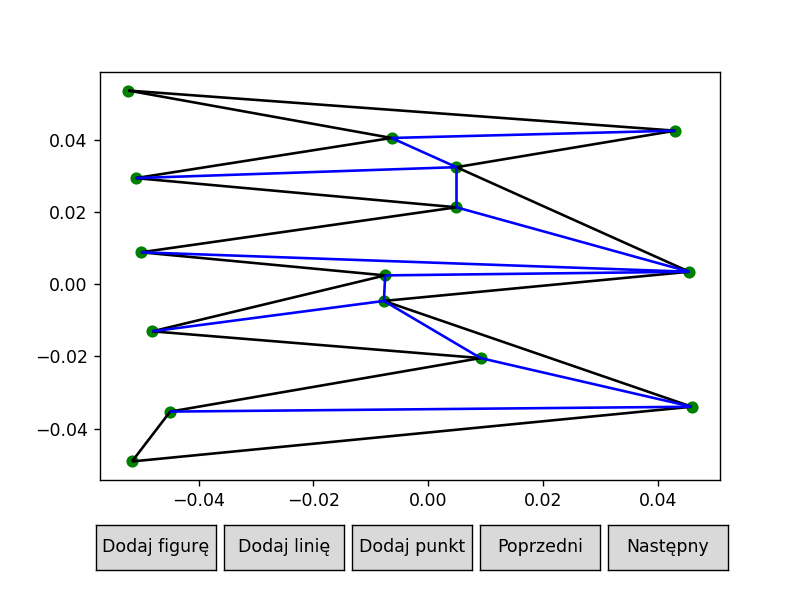

In [38]:
points_14 = points_from_plot(plot_14)
diagonals_14, scenes_14 = triangulation(points_14)
plot_14 = Plot(scenes_14)
print(f'Number of diagonals is {len(diagonals_14)}.')
print(f'Diagonals: {diagonals_14}.')
plot_14.draw()

Polygon is y-monotonic.
Number of diagonals is 12.
Diagonals: [((0.01889516399752708, 0.035009700083265136), (-0.048745965034730984, 0.05051215106365729)), ((0.024439518836236768, 0.022540337338167085), (0.01889516399752708, 0.035009700083265136)), ((0.024439518836236768, 0.022540337338167085), (-0.048745965034730984, 0.05051215106365729)), ((0.02355242206204322, 0.005015827534245509), (0.024439518836236768, 0.022540337338167085)), ((0.02355242206204322, 0.005015827534245509), (-0.048745965034730984, 0.05051215106365729)), ((-0.026568545679892273, 0.0013087196911082538), (0.02355242206204322, 0.005015827534245509)), ((0.043290325287849665, -0.003409417563793704), (-0.026568545679892273, 0.0013087196911082538)), ((0.0186733898039787, -0.012171672465754499), (-0.026568545679892273, 0.0013087196911082538)), ((-0.04541935213150518, -0.01790083913242116), (0.0186733898039787, -0.012171672465754499)), ((0.00825000270720451, -0.02497804501477411), (0.0186733898039787, -0.012171672465754499)),

<IPython.core.display.Javascript object>


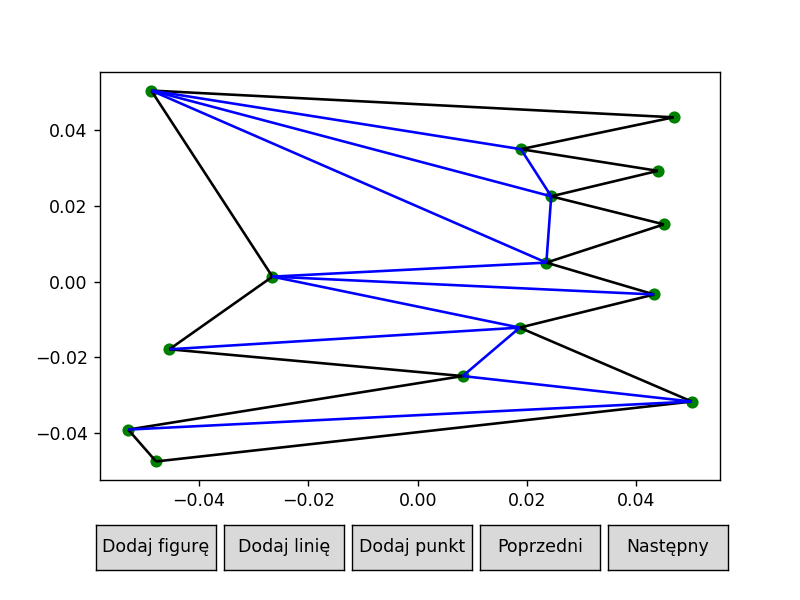

In [39]:
points_15 = points_from_plot(plot_15)
diagonals_15, scenes_15 = triangulation(points_15)
plot_15 = Plot(scenes_15)
print(f'Number of diagonals is {len(diagonals_15)}.')
print(f'Diagonals: {diagonals_15}.')
plot_15.draw()